# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display

import numpy as np
import torch
# from torch import nn
# from torch.optim import Adam
# from torch.autograd import Variable

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt

# Load output gridmet data (to verify agaist if wanted)

In [3]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 


# load files
#ds=xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]

# # Find min/max for each variable
# v1max = d.max(); v1min = d.min()
# v2max = dv2.max(); v2min = dv2.min()
# v3max = dv3.max(); v3min = dv3.min()
# v4max = dv4.max(); v4min = dv4.min()
# v5max = dv5.max(); v5min = dv5.min()
# v6max = dv6.max(); v6min = dv6.min()
# v7max = dv7.max(); v7min = dv7.min()
# v8max = dv8.max(); v8min = dv8.min()


# print("v1 max/min", v1max, v1min)
# print("v2 max/min", v2max, v2min)
# print("v3 max/min", v3max, v3min)
# print("v4 max/min", v4max, v4min)
# print("v5 max/min", v5max, v5min)
# print("v6 max/min", v6max, v6min)
# print("v7 max/min", v7max, v7min)
# print("v8 max/min", v8max, v8min)



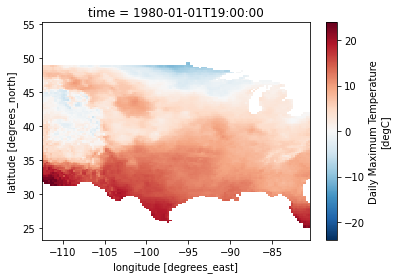

In [4]:
# plt.contourf(d[0,:,:])
# plt.colorbar()

dv2[0].plot()

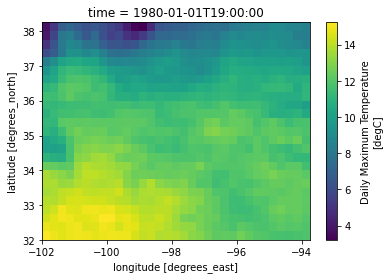

In [5]:
dv2[0].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).plot()

# Load input data

In [6]:
###########################
## LOAD ERAI data: daily ##
###########################

# load eraionmpi
#mndays = 11688      # 1979-2010
mstart = 365
mndays = 13515       # 1980-2016 
mnvars = 8*1
md = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

print("Days loaded", len(mdv7))

# Find min/max for each variable
mv1max = md.max(); mv1min = md.min()
mv2max = mdv2.max(); mv2min = mdv2.min()
mv3max = mdv3.max(); mv3min = mdv3.min()
mv4max = mdv4.max(); mv4min = mdv4.min()
mv5max = mdv5.max(); mv5min = mdv5.min()
mv6max = mdv6.max(); mv6min = mdv6.min()
mv7max = mdv7.max(); mv7min = mdv7.min()
mv8max = mdv8.max(); mv8min = mdv8.min()
print("mv1 max/min", mv1max, mv1min)
print("mv2 max/min", mv2max, mv2min)
print("mv3 max/min", mv3max, mv3min)
print("mv4 max/min", mv4max, mv4min)
print("mv5 max/min", mv5max, mv5min)
print("mv6 max/min", mv6max, mv6min)
print("mv7 max/min", mv7max, mv7min)
print("mv8 max/min", mv8max, mv8min)

# # synthetically create 16x16 input samples via bilinear scaling
# dd=[]
# ddo=[]
# for ii in range(mndays):
#     # input samples
#     rowdd = []
#     for iii in [0]: #range(4):
#     #for iii in range(4):
#        rowdd.append( cv2.resize(np.array(md[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv2[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv3[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv4[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv5[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv6[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv7[ii*1+iii]),(16,16)) )
#        rowdd.append( cv2.resize(np.array(mdv8[ii*1+iii]),(16,16)) )
#        # add doy
#        rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

#        dd.append(rowdd)

#     # output samples
#     rowddo = []
#     rowddo.append( np.array(d[ii])[0] )
#     rowddo.append( np.array(dv2[ii])[0] )
#     rowddo.append( np.array(dv3[ii])[0] )
#     rowddo.append( np.array(dv4[ii])[0] )
#     rowddo.append( np.array(dv5[ii])[0] )
#     rowddo.append( np.array(dv6[ii])[0] )
#     rowddo.append( np.array(dv7[ii])[0] )
#     rowddo.append( np.array(dv8[ii])[0] )
#     ddo.append(rowddo)
    
# # add channel for cos
# mnvars = 9


# do = np.array(d)

# print("d, do, md",d.shape, do.shape, np.array(md).shape)




Days loaded 13515
mv1 max/min <xarray.DataArray 'U' ()>
array(29.960123, dtype=float32) <xarray.DataArray 'U' ()>
array(-32.7581, dtype=float32)
mv2 max/min <xarray.DataArray 'V' ()>
array(30.62581, dtype=float32) <xarray.DataArray 'V' ()>
array(-32.324654, dtype=float32)
mv3 max/min <xarray.DataArray 'Q' ()>
array(0.01768149, dtype=float32) <xarray.DataArray 'Q' ()>
array(4.8779977e-05, dtype=float32)
mv4 max/min <xarray.DataArray 'T' ()>
array(294.80206, dtype=float32) <xarray.DataArray 'T' ()>
array(228.65608, dtype=float32)
mv5 max/min <xarray.DataArray 'Z' ()>
array(3278.9453, dtype=float32) <xarray.DataArray 'Z' ()>
array(2396.74, dtype=float32)
mv6 max/min <xarray.DataArray 'Z' ()>
array(6005.7915, dtype=float32) <xarray.DataArray 'Z' ()>
array(4669.179, dtype=float32)
mv7 max/min <xarray.DataArray 'U' ()>
array(98.96818, dtype=float32) <xarray.DataArray 'U' ()>
array(-43.84638, dtype=float32)
mv8 max/min <xarray.DataArray 'V' ()>
array(75.44277, dtype=float32) <xarray.DataArray

In [10]:
samples = [md,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8]
np.array(samples).shape

(8, 13515, 18, 18)

In [12]:
# cast samples into tensors

# input samples
samples = [md,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8]
samples = torch.tensor(np.array(samples))
samples.transpose_(0, 1)   # in place axis swap

# output samples
osamples = [dv1,dv2,dv3,dv4,dv5,dv6,dv7,dv8]
osamples = torch.tensor(np.array(osamples))
osamples.transpose_(0, 1)   # in place axis swap
osamples.shape


# osamples = []    # 20x20 samples
# for t in range(ndays):
#     osamples.append(do[t])
# print("osamples", np.array(osamples).shape)
# osamples = torch.tensor(np.reshape(osamples, (ndays, nvars, res, res)))
# print("osamples max min",osamples.max(), osamples.min())

# # debug
# np.save("delme.npy", samples[0,2])
# #np.save("delme.npy", mdv3[0])
# print("DONEDONE\n\n", mdv3[0][0].shape)


torch.Size([13515, 8, 128, 128])

In [13]:
##################################
## convert in batches of 1 #000 ##
##################################

#input_img = samples[0:1].cuda()
#print("input_img", input_img.shape)
#corrected_img = generator(input_img).data.cpu() 
#print("corrected_img", corrected_img.shape)

mb = 1

raw_ires = len(samples[0][0][0])
raininput = torch.zeros(mnvars,raw_ires,raw_ires)
dryinput = torch.zeros(mnvars,raw_ires,raw_ires)

# raininput = copy.deepcopy(d[0])
# dryinput = torch.zeros(mnvars,raw_ires,raw_ires)


raincount = 0
drycount = 0
#for ii in range(0,mndays,mb):
for ii in range(0,11688,1):
    doy = ii % 365.25
    #if doy >= 0 and doy <= 30:      # Dec
    if doy >= 120 and doy <= 150:   # May
        #input_img = samples[ii:ii+mb].cuda()
        isample = samples[ii]
        osample = osamples[ii]

        #mpr = dn(generated_img[:,0,:,:]).mean()
        #mpr = osample[0,35:60,42:75].mean()
        mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()
        print ("day, doy, mpr (mm/day)", ii, doy, mpr)
        if mpr > 1:
            raininput += isample
            raincount += 1
        if mpr < .3:
            dryinput += isample
            drycount += 1

        #print("generated_img", generated_img.shape)
        #downscaled_imgs[ii:ii+mb] = generated_img[0:mb].data.cpu()
        #print("corrected_img", downscaled_imgs.shape)

raininput /= raincount
dryinput /= drycount


day, doy, mpr (mm/day) 120 120.0 <xarray.DataArray 'prec' ()>
array(4.359236, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-04-30T19:00:00
day, doy, mpr (mm/day) 121 121.0 <xarray.DataArray 'prec' ()>
array(5.9995413, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-05-01T19:00:00
day, doy, mpr (mm/day) 122 122.0 <xarray.DataArray 'prec' ()>
array(4.318367, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-05-02T19:00:00
day, doy, mpr (mm/day) 123 123.0 <xarray.DataArray 'prec' ()>
array(0.28796574, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-05-03T19:00:00
day, doy, mpr (mm/day) 124 124.0 <xarray.DataArray 'prec' ()>
array(0.3341296, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-05-04T19:00:00
day, doy, mpr (mm/day) 125 125.0 <xarray.DataArray 'prec' ()>
array(1.218618, dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-05-05T19:00:00
day, doy, mpr (mm/day) 126 126.0 <xarray.DataArray 'prec' ()>
array(1.64

day, doy, mpr (mm/day) 1594 133.0 <xarray.DataArray 'prec' ()>
array(0.4624538, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-13T19:00:00
day, doy, mpr (mm/day) 1595 134.0 <xarray.DataArray 'prec' ()>
array(3.2070746, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-14T19:00:00
day, doy, mpr (mm/day) 1596 135.0 <xarray.DataArray 'prec' ()>
array(1.4731349, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-15T19:00:00
day, doy, mpr (mm/day) 1597 136.0 <xarray.DataArray 'prec' ()>
array(0.42811894, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-16T19:00:00
day, doy, mpr (mm/day) 1598 137.0 <xarray.DataArray 'prec' ()>
array(1.2883025, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-17T19:00:00
day, doy, mpr (mm/day) 1599 138.0 <xarray.DataArray 'prec' ()>
array(5.1919236, dtype=float32)
Coordinates:
    time     datetime64[ns] 1984-05-18T19:00:00
day, doy, mpr (mm/day) 1600 139.0 <xarray.DataArray 'prec' ()>


day, doy, mpr (mm/day) 3411 123.75 <xarray.DataArray 'prec' ()>
array(12.519634, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-04T19:00:00
day, doy, mpr (mm/day) 3412 124.75 <xarray.DataArray 'prec' ()>
array(2.3531063, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-05T19:00:00
day, doy, mpr (mm/day) 3413 125.75 <xarray.DataArray 'prec' ()>
array(0.03215629, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-06T19:00:00
day, doy, mpr (mm/day) 3414 126.75 <xarray.DataArray 'prec' ()>
array(1.103661, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-07T19:00:00
day, doy, mpr (mm/day) 3415 127.75 <xarray.DataArray 'prec' ()>
array(1.3735877, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-08T19:00:00
day, doy, mpr (mm/day) 3416 128.75 <xarray.DataArray 'prec' ()>
array(0.8638231, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-05-09T19:00:00
day, doy, mpr (mm/day) 3417 129.75 <xarray.DataArray 'prec

day, doy, mpr (mm/day) 4894 145.75 <xarray.DataArray 'prec' ()>
array(0.02876644, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-05-26T19:00:00
day, doy, mpr (mm/day) 4895 146.75 <xarray.DataArray 'prec' ()>
array(0.4691107, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-05-27T19:00:00
day, doy, mpr (mm/day) 4896 147.75 <xarray.DataArray 'prec' ()>
array(1.5684291, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-05-28T19:00:00
day, doy, mpr (mm/day) 4897 148.75 <xarray.DataArray 'prec' ()>
array(4.619112, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-05-29T19:00:00
day, doy, mpr (mm/day) 4898 149.75 <xarray.DataArray 'prec' ()>
array(3.8326197, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-05-30T19:00:00
day, doy, mpr (mm/day) 5234 120.5 <xarray.DataArray 'prec' ()>
array(1.78151, dtype=float32)
Coordinates:
    time     datetime64[ns] 1994-05-01T19:00:00
day, doy, mpr (mm/day) 5235 121.5 <xarray.DataArray 'prec' ()

day, doy, mpr (mm/day) 6711 136.5 <xarray.DataArray 'prec' ()>
array(0.14637241, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-17T19:00:00
day, doy, mpr (mm/day) 6712 137.5 <xarray.DataArray 'prec' ()>
array(0.45326456, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-18T19:00:00
day, doy, mpr (mm/day) 6713 138.5 <xarray.DataArray 'prec' ()>
array(0.03602079, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-19T19:00:00
day, doy, mpr (mm/day) 6714 139.5 <xarray.DataArray 'prec' ()>
array(0.08162723, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-20T19:00:00
day, doy, mpr (mm/day) 6715 140.5 <xarray.DataArray 'prec' ()>
array(0.06361707, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-21T19:00:00
day, doy, mpr (mm/day) 6716 141.5 <xarray.DataArray 'prec' ()>
array(0.04790766, dtype=float32)
Coordinates:
    time     datetime64[ns] 1998-05-22T19:00:00
day, doy, mpr (mm/day) 6717 142.5 <xarray.DataArray 'prec'

day, doy, mpr (mm/day) 8531 130.25 <xarray.DataArray 'prec' ()>
array(0.12521094, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-11T19:00:00
day, doy, mpr (mm/day) 8532 131.25 <xarray.DataArray 'prec' ()>
array(0.04206423, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-12T19:00:00
day, doy, mpr (mm/day) 8533 132.25 <xarray.DataArray 'prec' ()>
array(5.5320015, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-13T19:00:00
day, doy, mpr (mm/day) 8534 133.25 <xarray.DataArray 'prec' ()>
array(4.3534718, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-14T19:00:00
day, doy, mpr (mm/day) 8535 134.25 <xarray.DataArray 'prec' ()>
array(8.039038, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-15T19:00:00
day, doy, mpr (mm/day) 8536 135.25 <xarray.DataArray 'prec' ()>
array(18.693975, dtype=float32)
Coordinates:
    time     datetime64[ns] 2003-05-16T19:00:00
day, doy, mpr (mm/day) 8537 136.25 <xarray.DataArray 'pre

day, doy, mpr (mm/day) 10351 124.0 <xarray.DataArray 'prec' ()>
array(0.0404201, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-04T19:00:00
day, doy, mpr (mm/day) 10352 125.0 <xarray.DataArray 'prec' ()>
array(5.8034787, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-05T19:00:00
day, doy, mpr (mm/day) 10353 126.0 <xarray.DataArray 'prec' ()>
array(12.039736, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-06T19:00:00
day, doy, mpr (mm/day) 10354 127.0 <xarray.DataArray 'prec' ()>
array(23.85312, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-07T19:00:00
day, doy, mpr (mm/day) 10355 128.0 <xarray.DataArray 'prec' ()>
array(1.9896324, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-08T19:00:00
day, doy, mpr (mm/day) 10356 129.0 <xarray.DataArray 'prec' ()>
array(0.7578199, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-09T19:00:00
day, doy, mpr (mm/day) 10357 130.0 <xarray.DataArray 'prec'

# Plots

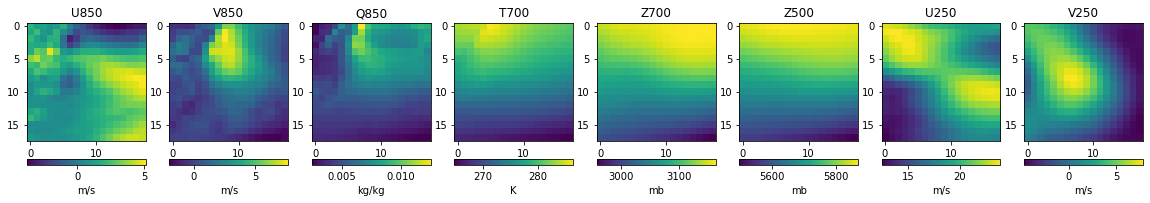

In [14]:
# plot average rain inputs
varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    plot = axarr[ii].imshow(raininput[ii])
    cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
    cbar.set_label(units[ii])
    axarr[ii].set_title(varmames[ii])
    


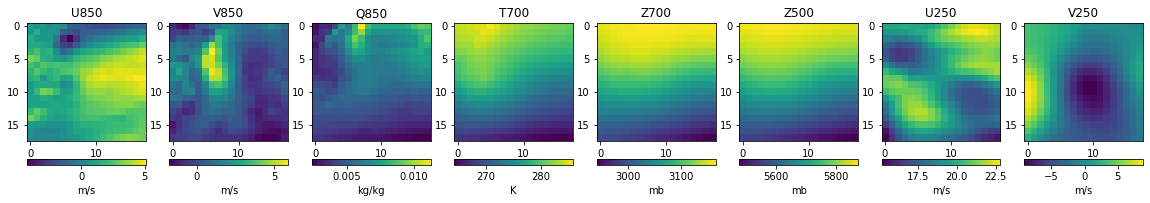

In [16]:
# plot average dry inputs
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    plot = axarr[ii].imshow(dryinput[ii])
    cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
    cbar.set_label(units[ii])
    axarr[ii].set_title(varmames[ii])


In [17]:
# # what about the cos() channel
# print(raininput[8].mean(), dryinput[8].mean())